# Company Data Analysis

### • Read the CSV file

In [119]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest
%matplotlib inline
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import cm
from scipy.stats import f_oneway

In [120]:
#Read the CSV file.

df = pd.read_csv('CompanyX_EU.csv')


## 2. Data exploration:
### • Check the datatypes of each attribute.


In [121]:
# Check the datatypes of each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Startup         662 non-null    object
 1   Product         656 non-null    object
 2   Funding         448 non-null    object
 3   Event           662 non-null    object
 4   Result          662 non-null    object
 5   OperatingState  662 non-null    object
dtypes: object(6)
memory usage: 31.2+ KB


### • Check for null values in the attributes

In [122]:
# Check for null values in the attributes

df.isna().sum()

Startup             0
Product             6
Funding           214
Event               0
Result              0
OperatingState      0
dtype: int64

## 3. Data preprocessing & visualisation:
### • Drop the null values

In [123]:
# Check for null values after droping it 

df1 = df.dropna().copy(deep=True)
df1.dropna(inplace=True)
df1.isna().sum()

Startup           0
Product           0
Funding           0
Event             0
Result            0
OperatingState    0
dtype: int64

### • Convert the ‘Funding’ features to a numerical value.

In [124]:
# Convert the ‘Funding’ features to a numerical value.

#df1.loc[:,'Funds_in_million'] = df1['Funding'].apply(lambda x: float(x[1:-1])/1000 if x[-1]=='K' else float(x[1:-1]))
df1.loc[:,'Funds_in_million'] = df1['Funding'].apply(lambda x: float(x[1:-1])/1000 if x[-1] == 'K' else (float(x[1:-1])*1000 if x[-1] == 'B' else float(x[1:-1])))
df1.head()

,Startup,Product,Funding,Event,Result,OperatingState,Funds_in_million
1,3DLT,3dlt.com,$630K,Disrupt NYC 2013,Contestant,Closed,0.63
3,3Dprintler,3dprintler.com,$1M,Disrupt NY 2016,Audience choice,Operating,1.00
5,5to1,5to1.com,$19.3M,TC50 2009,Contestant,Acquired,19.30
6,8 Securities,8securities.com,$29M,Disrupt Beijing 2011,Finalist,Operating,29.00
10,AdhereTech,adheretech.com,$1.8M,Hardware Battlefield 2014,Contestant,Operating,1.80


In [125]:
# Checking the description and info of the data for a cross check. 
df1.describe()

,Funds_in_million
count,446.000000
mean,17.241489
std,90.483710
min,0.005000
25%,0.745250
50%,2.200000
75%,9.475000
max,1700.000000


In [126]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 1 to 661
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Startup           446 non-null    object 
 1   Product           446 non-null    object 
 2   Funding           446 non-null    object 
 3   Event             446 non-null    object 
 4   Result            446 non-null    object 
 5   OperatingState    446 non-null    object 
 6   Funds_in_million  446 non-null    float64
dtypes: float64(1), object(6)
memory usage: 27.9+ KB


### • Plot box plot for funds in million.

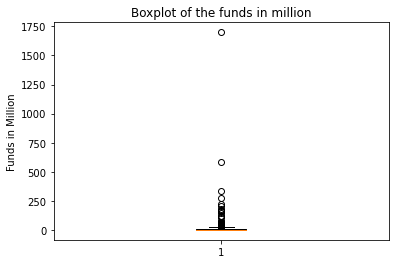

In [127]:
# Plot box plot for funds in million

plot=plt.boxplot(df1['Funds_in_million'])
plt.title('Boxplot of the funds in million')
plt.ylabel("Funds in Million")
plt.show()

### • Get the lower fence from the box plot.

In [128]:
#  Get the lower fence from the box plot

plot['caps'][0].get_data()[1][1]

0.005

### • Check number of outliers greater than upper fence.


In [129]:
# Upper Fence

up_fen = plot['caps'][1].get_data()[1][1]   
up_fen

22.0

In [130]:
# Number of Outliers

outliers = len(df1[df1.Funds_in_million > up_fen])
outliers

60

### • Drop the values that are greater than upper fence.


In [131]:
# Drop the values that are greater than upper fence

df1.drop(df1[df1.Funds_in_million > up_fen].index, inplace = True)
df1.Funds_in_million.max()

22.0

In [132]:
df1.Funds_in_million.min()

0.005

### • Plot the box plot after dropping the values.


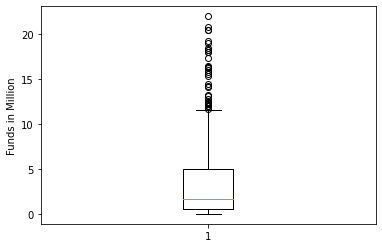

In [133]:
# Plot the box plot after dropping the values

plot = plt.boxplot(df1.Funds_in_million)
plt.ylabel('Funds in Million')
plt.show()

### • Check frequency of the OperatingState features classes.

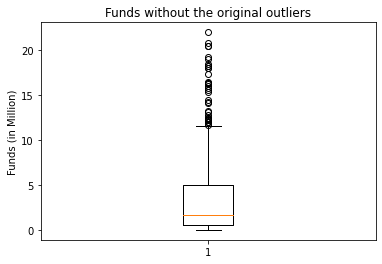

In [134]:
# Check frequency of the OperatingState features classes

plot = plt.boxplot(df1.Funds_in_million)
plt.title('Funds without the original outliers')
plt.ylabel('Funds (in Million)')
plt.show()

In [135]:
# Check frequency of the OperatingState features classes

df1['OperatingState'].value_counts()

Operating    275
Closed        56
Acquired      55
Name: OperatingState, dtype: int64

### • Plot a distribution plot for Funds in million.

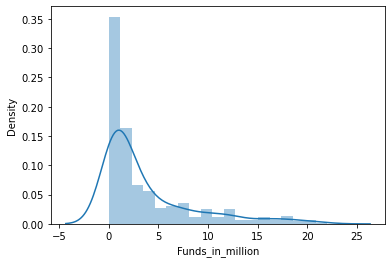

In [136]:
# Plot a distribution plot for Funds in million.
sns.distplot(df1.Funds_in_million)
plt.show()

### • Plot distribution plots for companies still operating and companies that closed.

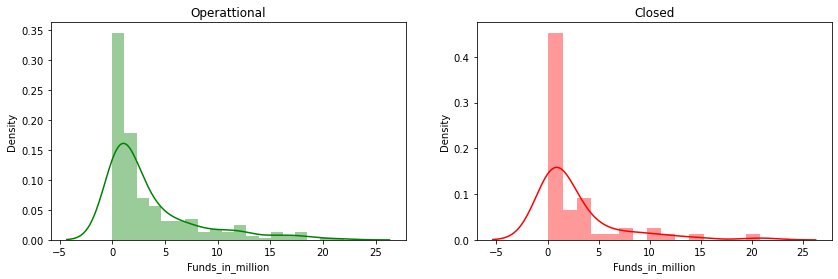

In [137]:
# Plot distribution plots for companies still operating and companies that closed

fig, ax = plt.subplots(1,2)

fig.set_figheight(4)
fig.set_figwidth(14)

sns.distplot(df1.loc[df1['OperatingState'] == 'Operating', 'Funds_in_million'], ax = ax[0],color='green')
sns.distplot(df1.loc[df1['OperatingState'] =='Closed', 'Funds_in_million'], ax = ax[1],color='Red')

ax[0].set_title('Operattional')
ax[1].set_title('Closed')
plt.show()

# Statistical analysis:
### - Is there any significant difference between Funds raised by companies that are still operating vs companies that closed down?
### -   Write the null hypothesis and alternative hypothesis.
### - Test for significance and conclusion

In [138]:
# Statistical analysis:

alpha=0.05
sample1 = df1.loc[df1.OperatingState == 'Operating', 'Funds_in_million']
sample2 = df1.loc[df1.OperatingState =='Closed', 'Funds_in_million']
test_statistic, p_value = ztest(sample1, sample2)
print('p_value is : ', p_value)
print('alpha is : ', alpha)

p_value is :  0.1922631485716917
alpha is :  0.05


### • Make a copy of the original data frame.


In [139]:
# • Make a copy of the original data frame

df2 = df1.dropna().copy(deep=True)
df2.head()

,Startup,Product,Funding,Event,Result,OperatingState,Funds_in_million
1,3DLT,3dlt.com,$630K,Disrupt NYC 2013,Contestant,Closed,0.63
3,3Dprintler,3dprintler.com,$1M,Disrupt NY 2016,Audience choice,Operating,1.00
5,5to1,5to1.com,$19.3M,TC50 2009,Contestant,Acquired,19.30
10,AdhereTech,adheretech.com,$1.8M,Hardware Battlefield 2014,Contestant,Operating,1.80
11,AdRocket,adrocket.com,$1M,TC50 2008,Contestant,Closed,1.00


### • Check frequency distribution of Result variable.

In [140]:
# Check frequency distribution of Result variable

df2['Result'].value_counts()

Contestant         282
Finalist            52
Audience choice     20
Winner              17
Runner up           15
Name: Result, dtype: int64

### • Calculate percentage of winners that are still operating and percentage of contestants that are still operating


In [141]:
# • Calculate percentage of winners that are still operating and percentage of contestants that are still operating

print(df2.groupby('Result').OperatingState.value_counts())

cont_op=(332/488)*100
win_op=(133/174)*100
print('The percentage of Contestants operating is : ',cont_op)
print('The percentage of Winners operating is : ', win_op)

Result           OperatingState
Audience choice  Operating          18
                 Closed              2
Contestant       Operating         194
                 Closed             49
                 Acquired           39
Finalist         Operating          37
                 Acquired           10
                 Closed              5
Runner up        Operating          14
                 Acquired            1
Winner           Operating          12
                 Acquired            5
Name: OperatingState, dtype: int64
The percentage of Contestants operating is :  68.0327868852459
The percentage of Winners operating is :  76.4367816091954


In [142]:
#• Write your hypothesis comparing the proportion of companies that are operating between winners and contestants:
 #Write the null hypothesis and alternative hypothesis.
# Test for significance and conclusion

### • Check distribution of the Event variable.

In [143]:
# • Check distribution of the Event variable

df2['Event'].value_counts()

TC50 2008                    25
TC40 2007                    22
Disrupt NY 2015              21
Disrupt NYC 2012             19
Disrupt SF 2011              19
TC50 2009                    19
Disrupt NYC 2013             19
Disrupt SF 2015              19
Disrupt SF 2013              19
Disrupt SF 2014              19
Disrupt SF 2016              17
Disrupt NY 2016              16
Disrupt NYC 2011             15
Disrupt SF 2012              15
Disrupt NYC 2014             15
Disrupt SF 2010              13
Hardware Battlefield 2014    12
Hardware Battlefield 2016    12
Disrupt London 2015          11
Disrupt EU 2014              10
Hardware Battlefield 2015    10
Disrupt NYC 2010             10
Disrupt London 2016          10
Disrupt EU 2013               9
-                             6
Disrupt Beijing 2011          4
Name: Event, dtype: int64

### • Select only the Event that has disrupt keyword from 2013 onwards.

In [144]:
# • Select only the Event that has disrupt keyword from 2013 onwards.

events = df1[df1['Event'].apply(lambda x: 'Disrupt' in x and int(x[-4:]) >= 2013)]['Event']
selected_events = df1[df1['Event'].apply(lambda x: 'Disrupt' in x and int(x[-4:]) >= 2013)]['Event'].value_counts()  
selected_events

Disrupt NY 2015        21
Disrupt SF 2013        19
Disrupt SF 2014        19
Disrupt SF 2015        19
Disrupt NYC 2013       19
Disrupt SF 2016        17
Disrupt NY 2016        16
Disrupt NYC 2014       15
Disrupt London 2015    11
Disrupt London 2016    10
Disrupt EU 2014        10
Disrupt EU 2013         9
Name: Event, dtype: int64

In [145]:
#df1=pd.to_numeric(df1.Event, errors='coerce')
#df1.isna().sum()
#df1.head()
#df1['Year']= df1['Event'].apply(lambda x: x[-4:]).astype('int')

### Write and perform your hypothesis along with significance test comparing the funds raised by companies across NY, SF and EU events from 2013 onwards


In [146]:
# Write and perform your hypothesis along with significance test comparing the funds raised by companies across NY, SF and EU events from
# 2013 onwards

events_SF = df1.loc[events[events.apply(lambda x: 'SF' in x)].index, 'Funds_in_million']
events_NY = df1.loc[events[events.apply(lambda x: 'NY' in x)].index, 'Funds_in_million'] 
events_EU = df1.loc[events[events.apply(lambda x: 'EU' in x or 'London' in x)].index, 'Funds_in_million'] 


print(f"Evenys held at SF :{len(events_NY)}, NewYork : {len(events_SF)} and Europe :{len(events_EU)}")

Evenys held at SF :71, NewYork : 74 and Europe :40


### • Plot the distribution plot comparing the 3 city events.

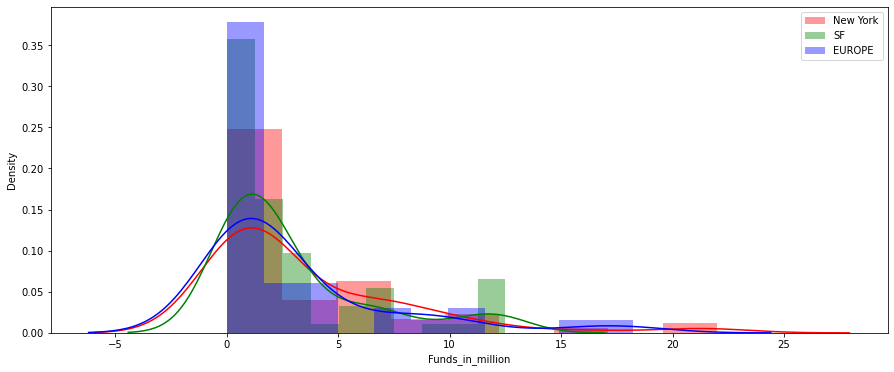

In [147]:
#• Plot the distribution plot comparing the 3 city events 

plt.figure(figsize=(15,6))
sns.distplot(events_NY, color = 'Red', label = 'New York')
sns.distplot(events_SF, color = 'Green', label = 'SF')
sns.distplot(events_EU, color = 'BLue', label = 'EUROPE')
plt.legend()
plt.show()

In [148]:
#Sample sizes are different across the three categories so we will perform ANOVA on samples of different sizes.

stat, p_value = f_oneway(events_NY, events_SF, events_EU)
if p_value <= alpha:
    print(f'p-value : {round(p_value, 3)} < alpha : {alpha}')
else:
    print(f'p-value : {round(p_value,3)} > alpha : {alpha}')
    

p-value : 0.628 > alpha : 0.05


## Final suggestion:

* Quality of the data:
    * The data looks good all of them were used for the analysis and no major correction were needed nor the data were imbalance.

* Quantity of the data:
    * The data quality could be much better, if the missing data were present.
    
* 3V’s of the data:
    * Volume is acceptable as most of the data was utilized and not major changes were done.
    *In terms of Velocity and Variety of the data, we cannot suggest much as the data is not generate in real-time nor it was unstructured or were Human or Machine generated.